In [6]:
%run ~/.python/init.ipynb

In [7]:
import torch
from torchvision import transforms
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

In [8]:
root = Path('/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic-regression/')
train_path = root / 'train'
test_path = root / 'test'

In [53]:
# class CARLADataset(torch.utils.data.Dataset):
#     def __init__(self, root, transforms=None):
#         self.root = root
#         self.transforms = transforms
#         # load all image files, sorting them to ensure that they are aligned
#         self.imgs = sorted([p.parts[-1] for p in self.root.glob("video*.npy")])
#         self.labels = sorted([p.parts[-1] for p in self.root.glob("coords*.npy")])

#     def __getitem__(self, idx):
#         # load images and masks         
#         img = np.load(self.root / self.imgs[idx])
#         target = np.load(self.root / self.labels[idx])

#         # use x,y only
#         target = target[[0,1]]
            
#         if self.transforms is not None:
#             img = self.transforms(img)

#         return img, target

#     def __len__(self):
#         return len(self.imgs)
    
# def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
#     since = time.time()

#     best_model_wts = copy.deepcopy(model.state_dict())
#     best_loss = np.float('inf')

#     for epoch in range(num_epochs):
#         print(f'Epoch {epoch}/{num_epochs - 1}')
#         print('-' * 10)

#         # Each epoch has a training and validation phase
#         for phase in ['train', 'test']:
#             if phase == 'train':
#                 model.train()  # Set model to training mode
#             else:
#                 model.eval()   # Set model to evaluate mode

#             running_loss = 0.0

#             # Iterate over data.
#             for inputs, labels in dataloaders[phase]:
#                 inputs = inputs.to(device)
#                 labels = labels.to(device).float()

#                 # zero the parameter gradients
#                 optimizer.zero_grad()

#                 # forward
#                 # track history if only in train
#                 with torch.set_grad_enabled(phase == 'train'):
#                     outputs = model(inputs)
#                     loss = criterion(outputs, labels)
#                     # backward + optimize only if in training phase
#                     if phase == 'train':
#                         loss.backward()
#                         optimizer.step()

#                 # statistics
#                 running_loss += loss.item() * inputs.size(0)
#             if phase == 'train':
#                 scheduler.step()

#             epoch_loss = running_loss / dataset_sizes[phase]

#             print(f'{phase} Loss: {epoch_loss:.4f}')

#             # deep copy the model
#             if phase == 'test' and epoch_loss < best_loss:
#                 best_loss = epoch_loss
#                 best_model_wts = copy.deepcopy(model.state_dict())

#         print()

#     time_elapsed = time.time() - since
#     print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
#     print(f'Best val loss: {best_loss:4f}')

#     # load best model weights
#     model.load_state_dict(best_model_wts)
#     return model

In [54]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    

In [61]:
data_transforms = {
    'train': transforms.Compose([
#         transforms.ToPILImage(),
#         transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
#         transforms.ToPILImage(),
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

dataloaders = {
    "train": torch.utils.data.DataLoader(
        CARLADataset(train_path, data_transforms['train']),
        batch_size=4,
        shuffle=True,
        num_workers=4),
    'test': torch.utils.data.DataLoader(
        CARLADataset(test_path, data_transforms['test']),
        batch_size=4,
        shuffle=True,
        num_workers=4)
}

dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'test']}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [62]:
dataset_sizes

{'train': 5000, 'test': 1000}

In [63]:
dataset_sizes

{'train': 5000, 'test': 1000}

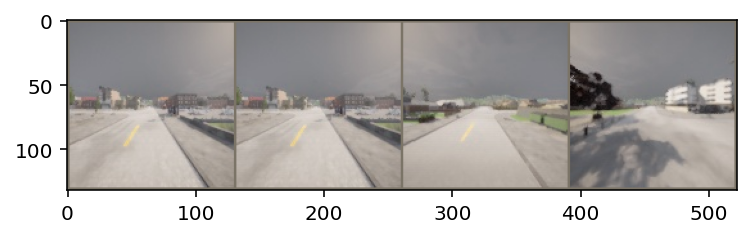

In [64]:
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out)

In [65]:
# model_conv = torchvision.models.resnet18(pretrained=True)

# # Parameters of newly constructed modules have requires_grad=True by default
# num_ftrs = model_conv.fc.in_features
# model_conv.fc = nn.Linear(num_ftrs, 2)

# model_conv = model_conv.to(device)

# criterion = nn.MSELoss()

# # optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
# optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)

# # Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 3183.7895
test Loss: 7148.3693

Epoch 1/24
----------
train Loss: 448.4705
test Loss: 6688.2737

Epoch 2/24
----------
train Loss: 172.3789
test Loss: 3715.9352

Epoch 3/24
----------
train Loss: 99.7073
test Loss: 5309.0740

Epoch 4/24
----------
train Loss: 76.2728
test Loss: 4430.6140

Epoch 5/24
----------
train Loss: 50.3641
test Loss: 4912.6034

Epoch 6/24
----------
train Loss: 44.7073
test Loss: 4827.6246

Epoch 7/24
----------
